# Imports

In [1]:
import numpy as np
import sys
import cmath
from numba import jit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

# Use LaTeX in the plots
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
def get_GQ_weights_and_locs(M):
    """
    Lookup for the weights and locs for Gauss quadrature.
    
    Input:
    ==================
    M: Order of the quadrature 
    
    Output:
    ==================
    wi: Quadrature weights 
    xi: Quadrature locations used in the approximation
    """
    if(M == 1):
        wi = [2,]
        xi = [0,]
    elif(M == 2):
        wi = [1.0,
              1.0]
        xi = [-0.5773502691896257,
               0.5773502691896257]
    elif(M == 3):
        wi = [0.8888888888888888,
              0.5555555555555556,
              0.5555555555555556]
        xi = [0.0,
              -0.7745966692414834,
               0.7745966692414834]
    elif(M == 4):
        wi = [0.6521451548625461,
                    0.6521451548625461,
                    0.3478548451374538,
                    0.3478548451374538]
        xi = [-0.3399810435848563,
                       0.3399810435848563,
                      -0.8611363115940526,
                       0.8611363115940526]
    elif(M == 5):
        wi = [0.5688888888888889,
                    0.4786286704993665,
                    0.4786286704993665,
                    0.2369268850561891,
                    0.2369268850561891]
        xi = [0.0,
               -0.5384693101056831,
               0.5384693101056831,
               -0.906179845938664,
               0.906179845938664]
    elif(M == 6):
        wi = [0.3607615730481386,
              0.3607615730481386,
              0.467913934572691,
              0.467913934572691,
              0.1713244923791704,
              0.1713244923791704]
        xi = [0.6612093864662645,
                -0.6612093864662645,
                -0.2386191860831969,
                0.2386191860831969,
                -0.932469514203152,
                0.932469514203152]
    elif(M == 7):
        wi = [ 0.41795918,  
               0.38183005,  
               0.38183005,  
               0.27970539,  
               0.27970539,
               0.12948497,  
               0.12948497]
        xi = [ 0.,  
               0.40584515, 
               -0.40584515, 
               -0.74153119,  
               0.74153119,
               -0.94910791,  
               0.94910791]
    elif(M == 8):
        wi = [0.3626837833783620,0.3626837833783620,0.3137066458778873,0.3137066458778873,
            0.2223810344533745,0.2223810344533745,0.1012285362903763,0.1012285362903763]
        xi = [-0.1834346424956498,0.1834346424956498,-0.5255324099163290,0.5255324099163290,
            -0.7966664774136267,0.7966664774136267,-0.9602898564975363,0.9602898564975363]
    elif(M == 9):
        wi = [ 0.33023936,  0.18064816,  0.18064816,  0.08127439,  0.08127439,
                0.31234708,  0.31234708,  0.2606107 ,  0.2606107 ]
        xi = [ 0.        , -0.83603111,  0.83603111, -0.96816024,  0.96816024,
               -0.32425342,  0.32425342, -0.61337143,  0.61337143]
    elif(M == 10):
        wi = [ 0.29552422,  0.29552422,  0.26926672,  0.26926672,  0.21908636,
                0.21908636,  0.14945135,  0.14945135,  0.06667134,  0.06667134]
        xi = [-0.14887434,  0.14887434, -0.43339539,  0.43339539, -0.67940957,
                0.67940957, -0.86506337,  0.86506337, -0.97390653,  0.97390653]

    return np.array(wi), np.array(xi)

### Function to Compute the Cell Averages

In [3]:
def get_cell_averages(q, x_bar, wi, xi, dx, M):
    
    N = x_bar.shape[0]
    
    # For Euler, this needs 3 components
    q_bar = np.zeros([3,N])    
    
    # Compute the cell averages (M is the order of the quadrature)
    for i in range(M):

        q_bar += wi[i]*q(x_bar + 0.5*xi[i]*dx) 

    q_bar *= 0.5
    
    return q_bar

### Some error functions

In [4]:
# L_1 error
def get_L_1_error(U_numerical, U_exact, dx):
    
    return dx*np.linalg.norm(U_numerical - U_exact,1)

# L_2 error
def get_L_2_error(U_numerical, U_exact, dx):

    return (dx**(0.5))*np.linalg.norm(U_numerical - U_exact,2)

# L_infinity error
def get_L_infinity_error(U_numerical, U_exact):
    
    return np.linalg.norm(U_numerical - U_exact,np.inf)

# Euler Equations:

In 1D, the Euler Equations are given as

$$
\begin{cases}
    \mathbf{q}_t + \partial_x F(\mathbf{q}) = 0, \\
\end{cases}
$$
where 
\begin{align*}
    \mathbf{q} =
    \begin{bmatrix}
          \rho \\
          \rho u \\
          E
    \end{bmatrix}
    ,\quad 
    F(\mathbf{q}) =
    \begin{bmatrix}
          \rho u \\
          \rho u^2 + p \\
          (E + p)u
    \end{bmatrix}.
\end{align*}

We consider the following discretizations:
1. Fifth order FV-WENO reconstruction, with an HLLC flux, and third order TVD-RK time stepping.
2. Fourth order RBF FV-WENO reconstruction, with an HLLC flux, and third order TVD-RK time stepping.

### Equation of State

Note that we use the equation of state:
\begin{equation*}
    p = (\gamma - 1)(E - \frac{1}{2}\rho u^2), \quad c = \sqrt{\frac{\gamma p}{\rho}}
\end{equation*}
with $\gamma = 7/5$ (atmospheric gases) and c being the local speed of sound in the fluid.

In [5]:
gamma = 1.4

###  Initial condition for Sod's problem defined on $[0,1]$  (See Hesthaven pg 17)

In [6]:
def sod_problem_init(x):

    # Get the number of cells
    N = x.shape[0]
    
    # There are 3 components (rho, rho_u, E)
    q0 = np.zeros([3,N])
    
    # Set the fields by looping over the grid points
    for i in range(N):
        
        if x[i] < 0.5:
            rho = 1.0
            u = 0.75
            p = 1.0
            
            E = p/(gamma - 1) + 0.5*rho*u**2
            
            q0[0,i] = rho
            q0[1,i] = rho*u
            q0[2,i] = E 
            
        else:
            rho = 0.125
            u = 0.0
            p = 0.1
            
            E = p/(gamma - 1) + 0.5*rho*u**2
            
            q0[0,i] = rho
            q0[1,i] = rho*u
            q0[2,i] = E 
    
    return q0

###  Initial condition for Lax's problem defined on $[0,1]$  (See Hesthaven pg 17)

In [7]:
def lax_problem_init(x):

    # Get the number of cells
    N = x.shape[0]
    
    # There are 3 components (rho, rho_u, E)
    q0 = np.zeros([3,N])
    
    # Set the fields by looping over the grid points
    for i in range(N):
        
        if x[i] < 0:
            rho = 0.445
            u = 0.698
            p = 3.528
            
            E = p/(gamma - 1) + 0.5*rho*u**2
            
            q0[0,i] = rho
            q0[1,i] = rho*u
            q0[2,i] = E 
            
        else:
            rho = 0.5
            u = 0.0
            p = 0.571
            
            E = p/(gamma - 1) + 0.5*rho*u**2
            
            q0[0,i] = rho
            q0[1,i] = rho*u
            q0[2,i] = E 
    
    return q0

###  Initial condition for the Shock-Entropy problem defined on $[-5,5]$  (See Hesthaven pg 17)

In [8]:
def shock_entropy_init(x):

    # Get the number of cells
    N = x.shape[0]
    
    # There are 3 components (rho, rho_u, E)
    q0 = np.zeros([3,N])
    
    # Set the fields by looping over the grid points
    for i in range(N):
        
        if x[i] < -4.0:
            
            # Defined via primitive variables 
            # and pressure. Can use these + EOS to 
            # get conserved variables
            rho = 3.857143
            u = 2.629369
            p = 10.33333
            
            E = p/(gamma - 1) + 0.5*rho*u**2
            
            q0[0,i] = rho
            q0[1,i] = rho*u
            q0[2,i] = E
            
        else:
            
            # Defined via primitive variables 
            # and pressure. Can use these + EOS to 
            # get conserved variables
            rho = 1.0 + 0.2*np.sin(5*x[i])
            u = 0.0
            p = 1.0
            
            E = p/(gamma - 1) + 0.5*rho*u**2
            
            q0[0,i] = rho
            q0[1,i] = rho*u
            q0[2,i] = E 
    
    return q0

###  Initial condition for Woodward-Colella defined on $[0,1]$ 

In [9]:
def blast_problem_init(x):

    # Get the number of cells
    N = x.shape[0]
    
    # There are 3 components (rho, rho_u, E)
    q0 = np.zeros([3,N])
    
    # Set the fields by looping over the grid points
    for i in range(N):
        
        if x[i] < 0.1:
            rho = 1.0
            u = 0
            p = 1000
            
            E = p/(gamma - 1) #+ 0.5*rho*u**2
            
            q0[0,i] = rho
            q0[1,i] = rho*u
            q0[2,i] = E 
            
        elif x[i] < 0.9:
            rho = 1.0
            u = 0
            p = 0.01
            
            E = p/(gamma - 1) #+ 0.5*rho*u**2
            
            q0[0,i] = rho
            q0[1,i] = rho*u
            q0[2,i] = E 
        else:
            rho = 1.0
            u = 0.0
            p = 100
            
            E = p/(gamma - 1) #+ 0.5*rho*u**2
            
            q0[0,i] = rho
            q0[1,i] = rho*u
            q0[2,i] = E 
    
    return q0

### Function to compute the max wave speeds for time integration

In [10]:
@jit(nopython=True) # Set "nopython" mode for best performance, equivalent to @njit
def get_max_wave_speed(q):

    # Retrive the number of grid cells and components
    N = q.shape[1]
    N_eqns = q.shape[0]
    
    # Retrieve each of the components of the current state
    rho = q[0,:]
    rho_u = q[1,:]
    E = q[2,:]
    
    # Primitive variable u
    u = rho_u/rho
    
    # Pressure (from the EOS)
    p = (gamma - 1)*(E - 0.5*rho*u**2)
    
    # Sound speed
    c = np.sqrt(gamma*np.abs(p/rho))
    
    # Initialize the speed
    max_speed = 0.0
    
    # Loop over the cells and compute the max wave speed
    for i in range(N):
        
        max_speed = max(max_speed, abs(u[i] - c[i]), abs(u[i]), abs(u[i] + c[i]))
    
    return max_speed

### Local Lax-Friedrichs Flux

In [11]:
@jit()
def LLxF(q_l,q_r):
    
    # Retrive the number of grid cells and components
    N = q_l.shape[1]
    N_eqns = q_l.shape[0]
    
    # Initialize the numerical flux
    numflux = np.zeros([N_eqns, N])
    
    # Loop over the grid cells and compute
    # the quantities needed for the flux
    for i in range(N):
    
        # Retrieve each of the components of the left state q_l:
        rho_l = q_l[0,i] # Density
        rho_u_l = q_l[1,i] # Momentum
        E_l = q_l[2,i] # Energy

        # Retrieve each of the components of the right state q_r:
        rho_r = q_r[0,i] # Density
        rho_u_r = q_r[1,i] # Momentum
        E_r = q_r[2,i] # Energy

        # Compute the Primitive variable u_l and u_r
        u_l = rho_u_l/rho_l
        u_r = rho_u_r/rho_r

        # Compute the pressure p(x) on the left and right states
        # using the EOS as well as the sound speed c
        p_l = (gamma - 1)*(E_l - 0.5*rho_l*u_l**2)
        p_r = (gamma - 1)*(E_r - 0.5*rho_r*u_r**2)
       
        c_l = np.sqrt(gamma*np.abs(p_l/rho_l))
        c_r = np.sqrt(gamma*np.abs(p_r/rho_r))
              
        # Estimate the max wave speeds for the Jacobian of the flux f'(q)
        s_max = max(abs(u_l - c_l), abs(u_l), abs(u_l + c_l))
        s_max = max(s_max, abs(u_r - c_r), abs(u_r), abs(u_r + c_r))
#         s_max *= 1.2

        # Evaluate the flux function on the left and right states
        f_l = np.empty([N_eqns])
        f_r = np.empty([N_eqns])
        
        # Density
        f_l[0] = rho_u_l 
        f_r[0] = rho_u_r 
        
        # Momentum
        f_l[1] = rho_l*u_l**2 + p_l
        f_r[1] = rho_r*u_r**2 + p_r
        
        # Energy
        f_l[2] = (E_l + p_l)*u_l
        f_r[2] = (E_r + p_r)*u_r

        # Use the upper bound on the wave speeds to add some dissipation
        numflux[:,i] = 0.5*( f_l + f_r - s_max*(q_r[:,i] - q_l[:,i]) )
            
    return numflux

### HLLC flux

In [12]:
# Per Numerical Methods for Conservation Laws by
# Jan Hesthaven pages 139 - 142
@jit()
def hllc(q_l,q_r):
    
    # Retrive the number of grid cells and components
    N = q_l.shape[1]
    N_eqns = q_l.shape[0]
    
    # Initialize the numerical flux
    numflux = np.zeros([N_eqns, N])
    
    # Loop over the grid cells and compute
    # the quantities needed for the flux
    for i in range(N):
    
        # Retrieve each of the components of the left state q_l:
        rho_l = q_l[0,i] # Density
        rho_u_l = q_l[1,i] # Momentum
        E_l = q_l[2,i] # Energy

        # Retrieve each of the components of the right state q_r:
        rho_r = q_r[0,i] # Density
        rho_u_r = q_r[1,i] # Momentum
        E_r = q_r[2,i] # Energy

        # Compute the Primitive variable u_l and u_r
        u_l = rho_u_l/rho_l
        u_r = rho_u_r/rho_r

        # Compute the pressure p(x) on the left and right states
        # using the EOS as well as the sound speed c
        p_l = (gamma - 1)*(E_l - 0.5*rho_l*u_l**2)
        p_r = (gamma - 1)*(E_r - 0.5*rho_r*u_r**2)
       
        c_l = np.sqrt(gamma*np.abs(p_l/rho_l))
        c_r = np.sqrt(gamma*np.abs(p_r/rho_r))
              
        # Estimate the wave speeds for the Jacobian of the flux f'(q)
        # s_l gives a lower bound on the wave speeds, while s_r gives an upper bound
        s_l = min(u_l - c_l, u_l, u_l + c_l)
        s_r = max(u_r - c_r, u_r, u_r + c_r)        

        # Evaluate the flux function on the left and right states
        f_l = np.empty([N_eqns])
        f_r = np.empty([N_eqns])
        
        # Density
        f_l[0] = rho_u_l 
        f_r[0] = rho_u_r 
        
        # Momentum
        f_l[1] = rho_l*u_l**2 + p_l
        f_r[1] = rho_r*u_r**2 + p_r
        
        # Energy
        f_l[2] = (E_l + p_l)*u_l
        f_r[2] = (E_r + p_r)*u_r

        # Compute the intermediate velocities s*
        s_star = (p_r - p_l + rho_u_l*(s_l - u_l) - rho_u_r*(s_r - u_r))/(rho_l*(s_l - u_l) - rho_r*(s_r - u_r))

        # Compute the Roe pressues
        p_lr = 0.5*(p_r + p_l + rho_l*(s_l - u_l)*(s_star - u_l) + rho_r*(s_star - u_r)*(s_r - u_r) )
    
        # D := [0, 1, s*]^T
        D = np.array([0.0, 1.0, s_star])
        
        # Now compute the intermediate states
        f_l_star = (s_star*(s_l*q_l[:,i] - f_l[:]) + s_l*p_lr*D)/(s_l - s_star)
        
        f_r_star = (s_star*(s_r*q_r[:,i] - f_r[:]) + s_r*p_lr*D)/(s_r - s_star)
        
        # Select the numerical flux according to equation (6.14)
        if s_l >= 0: 

            numflux[:,i] = f_l[:]

        elif s_star >= 0 and s_l <= 0: 

            numflux[:,i] = f_l_star[:]

        elif s_star <= 0 and s_r >= 0:

            numflux[:,i] = f_r_star[:]

        elif s_r <= 0:

            numflux[:,i] = f_r[:]
            
    return numflux

### Function to extend the grid data

In [13]:
@jit()
def get_extension(x, q, dx, num_ghost_cells, left_BC_type, right_BC_type, left_val = 0, right_val = 0):
    '''
     x is the array of cell centers
     q is the array of cell averages
     dx is the cell spacing
     num_ghost cells is the number of ghost cells used to pad each side of the domain
     left_BC_type, right_BC_type are strings the indicate the type of BC on each end of the grid dimension
     Left and right values (optional) are for Dirichlet conditions only   

    '''
    
    # Get the dimensions of q
    N = q.shape[0]
    
    x_ext = np.empty([N + 2*num_ghost_cells])
    q_ext = np.empty([N + 2*num_ghost_cells])

    # Fill the extended arrays with the interior points
    x_ext[num_ghost_cells:-num_ghost_cells] = x
    q_ext[num_ghost_cells:-num_ghost_cells] = q
    
    # Extend the grid 
    x_left = np.amin(x)
    x_right = np.amax(x)
    
    x_ext[0:num_ghost_cells] = x_left - np.arange(num_ghost_cells, 0, -1)*dx
    x_ext[-num_ghost_cells:] = x_right + np.arange(1, num_ghost_cells + 1, 1)*dx

    # Periodic
    if left_BC_type == 'P' or right_BC_type == 'P':
    
        # Left extension
        q_ext[0:num_ghost_cells] = q[-num_ghost_cells:]
        
        # Right extension
        q_ext[-num_ghost_cells:] = q[0:num_ghost_cells]
    
    # Dirichlet via constant extrapolation
    if left_BC_type == 'D':
        
        # Left extension
        q_ext[0:num_ghost_cells] = left_val
    
    # Dirichlet via constant extrapolation
    if right_BC_type == 'D':
    
        # Right extension    
        q_ext[-num_ghost_cells:] = right_val
        
    # Reflection
    if left_BC_type == 'R':
        
        # Left extension
        q_ext[0:num_ghost_cells] = q[num_ghost_cells-1::-1]
    
    # Reflection
    if right_BC_type == 'R':
    
        # Right extension    
        q_ext[-num_ghost_cells:] = q[-1:-num_ghost_cells-1:-1]
        
    return x_ext, q_ext

In [14]:
@jit()
def get_extension_sys(x, q, dx, num_ghost_cells, left_BC_type, right_BC_type):
    '''
     x is the array of cell centers
     q is the array of cell averages
     dx is the cell spacing
     num_ghost cells is the number of ghost cells used to pad each side of the domain
     left_BC_type, right_BC_type are strings the indicate the type of BC on each end of the grid dimension
    '''

    # Get the dimensions of q
    N = q.shape[1]
    N_eqns = q.shape[0]     
    
    x_ext = np.empty([N + 2*num_ghost_cells])
    q_ext = np.zeros([N_eqns, N + 2*num_ghost_cells])

    # Fill the extended arrays with the interior points
    x_ext[num_ghost_cells:-num_ghost_cells] = x
    q_ext[:, num_ghost_cells:-num_ghost_cells] = q
    
    # Extend the grid 
    x_left = np.amin(x)
    x_right = np.amax(x)
    
    x_ext[0:num_ghost_cells] = x_left - np.arange(num_ghost_cells, 0, -1)*dx
    x_ext[-num_ghost_cells:] = x_right + np.arange(1, num_ghost_cells + 1, 1)*dx

    # Periodic
    if left_BC_type == 'P' or right_BC_type == 'P':
    
        # Left extension
        q_ext[:,0:num_ghost_cells] = q[:,-num_ghost_cells:]
        
        # Right extension
        q_ext[:,-num_ghost_cells:] = q[:,0:num_ghost_cells]
    
    # Dirichlet via constant extrapolation
    if left_BC_type == 'D':
        
        # Left extension
        q_ext[0,0:num_ghost_cells] = q[0,0]
        q_ext[1,0:num_ghost_cells] = q[1,0]
        q_ext[2,0:num_ghost_cells] = q[2,0]
    
    # Dirichlet via constant extrapolation
    if right_BC_type == 'D':
        
        # Right extension    
        q_ext[0,-num_ghost_cells:] = q[0,-1]
        q_ext[1,-num_ghost_cells:] = q[1,-1]
        q_ext[2,-num_ghost_cells:] = q[2,-1]
        
    # Reflection
    if left_BC_type == 'R':
        
        # Left extension
        q_ext[0,0:num_ghost_cells] =  q[0,num_ghost_cells-1::-1]
        q_ext[1,0:num_ghost_cells] = -q[1,num_ghost_cells-1::-1]
        q_ext[2,0:num_ghost_cells] =  q[2,num_ghost_cells-1::-1]
    
    # Reflection
    if right_BC_type == 'R':
    
        # Right extension    
        q_ext[0,-num_ghost_cells:] =  q[0,-1:-num_ghost_cells-1:-1]
        q_ext[1,-num_ghost_cells:] = -q[1,-1:-num_ghost_cells-1:-1]
        q_ext[2,-num_ghost_cells:] =  q[2,-1:-num_ghost_cells-1:-1]
        
    return x_ext, q_ext

### Characteristic Decomposition

In [15]:
@jit()
def decomp(q):
    
    # Retrive the number of grid cells and components
    N = q.shape[1] - 1      # #(q) = N+1
    N_eqns = q.shape[0]     
    
    # Initialize variables for Roe's mean matrix
    w = np.zeros([N+1])
    v = np.zeros([N+1])
    h = np.zeros([N+1])
    
    # Initialize the left and right eigenvectors
    eig_l = np.zeros([N_eqns, N_eqns, N])
    eig_r = np.zeros([N_eqns, N_eqns, N])
    
    # Loop over the grid cells and compute
    # the quantities needed for the flux
    for i in range(N+1):
    
        # Retrieve each of the components of the state q:
        den = q[0,i] # Density
        mmt = q[1,i] # Momentum
        eng = q[2,i] # Energy

        # Compute the Primitive variable u
        vel = mmt/den

        # The pressure p(x) using the EOS
        pre = (gamma - 1)*(eng - 0.5*mmt*vel)
        
        # To construct Roe's mean matrix
        w[i] = np.sqrt(den)
        v[i] = vel
        h[i] = (eng + pre)/den  # total enthalpy

    # The max wave speed
    # s_max = max(s_maxs[0], s_maxs[2])
    
    for i in range(N):
        
        t0 = w[i] / ( w[i] + w[i+1] )
        t1 = 1 - t0
        vm = t0 * v[i] + t1 * v[i+1]
        hm = t0 * h[i] + t1 * h[i+1]
        qm = 0.5*vm*vm
        cm = np.sqrt( (gamma-1)*(hm - qm) )
        
        eig_r[0,0,i] = 1
        eig_r[0,1,i] = 1
        eig_r[0,2,i] = 1
        eig_r[1,0,i] = vm - cm
        eig_r[1,1,i] = vm 
        eig_r[1,2,i] = vm + cm
        eig_r[2,0,i] = hm - vm*cm
        eig_r[2,1,i] = qm
        eig_r[2,2,i] = hm + vm*cm
        
        rcm = 1/cm
        b1 = (gamma-1)*rcm*rcm
        eig_l[0,0,i] =  0.5*( b1*qm + vm*rcm )
        eig_l[0,1,i] = -0.5*( b1*vm + rcm )
        eig_l[0,2,i] =    0.5*b1
        eig_l[1,0,i] =    1 - b1*qm
        eig_l[1,1,i] =        b1*vm
        eig_l[1,2,i] =      - b1
        eig_l[2,0,i] =  0.5*( b1*qm - vm*rcm )
        eig_l[2,1,i] = -0.5*( b1*vm - rcm )
        eig_l[2,2,i] =    0.5*b1
        
    return eig_l, eig_r

### Base solver

In [16]:
def euler_solver(x, q_0, dx, CFL, FinalTime, m_flux, m_rhs, m_left_bc, m_right_bc):
    
    # Set the initial time
    time = 0
    
    # Copy the cell averages of the initial condition q_O
    # This is done so they aren't overwritten
    q = q_0.copy()
    
    k = 0
    while(time < FinalTime):
        k += 1
        # Max wave speed for Euler
        max_speed = get_max_wave_speed(q)
        
        # Enforce the time step restriction
        # Extra factor of 2 is so neighboring 
        # Riemann problems don't influence each other
        dt = CFL*dx/(2*max_speed) 
        if (k%100==0) :
            print(k, time, max_speed)

        # End case for the time step
        if time + dt > FinalTime:
            dt = FinalTime - time

        # Apply a 3rd order SSP-RK method
        # stage 1:
        rhs = m_rhs(x, q, m_flux, m_left_bc, m_right_bc)
        q1 = q + (dt/dx)*rhs

        # stage 2:
        rhs = m_rhs(x, q1, m_flux, m_left_bc, m_right_bc)
        q2 = (3*q + q1 + (dt/dx)*rhs)/4

        # stage 3:
        rhs = m_rhs(x,q2, m_flux, m_left_bc, m_right_bc)
        q = (q + 2*q2 + 2*(dt/dx)*rhs)/3
        
        # Increment for time
        time += dt
    return q

### Fifth-Order JS-WENO

In [17]:
@jit()
def WENO_5(v_locs):
    """
    Reconstructs the cell interfaces using data from cell averages and their centers via
    the WENO procedure. The reconstruction should be fifth order accurate. 
    
    Input:
    ===========
    v_locs: a 2m - 1 length array for the cell averages of all candidates used in the reconstruction procedure
    
    Output:
    ===========
    v_minus: Right side approximations to the left end of my cell
    """
    # Needed to prevent divide by zero
    epsilon = 1e-6
    
    # Compute the smoothness indicators for each of the stencils (identical for left and right values)
    beta_0 = 13/3*(v_locs[0] - 2*v_locs[1] + v_locs[2])**2 + (  v_locs[0] - 4*v_locs[1] + 3*v_locs[2])**2
    beta_1 = 13/3*(v_locs[1] - 2*v_locs[2] + v_locs[3])**2 + (  v_locs[1]                 - v_locs[3])**2
    beta_2 = 13/3*(v_locs[2] - 2*v_locs[3] + v_locs[4])**2 + (3*v_locs[2] - 4*v_locs[3] +   v_locs[4])**2
    
    # Compute the right interface values for each of the stencils 
    v_0 =  (1/3)*v_locs[0] - (7/6)*v_locs[1] + (11/6)*v_locs[2] # Left bias
    v_1 = -(1/6)*v_locs[1] + (5/6)*v_locs[2] + (1/3)*v_locs[3]  # Centered
    v_2 =  (1/3)*v_locs[2] + (5/6)*v_locs[3] - (1/6)*v_locs[4]  # Right
    
    # Right linear weights
    d_0 = 1/10
    d_1 = 3/5
    d_2 = 3/10
    
    # Compute the classical nonlinear weights using the smoothness indicators
    w_0 = d_0/(epsilon + beta_0)**2
    w_1 = d_1/(epsilon + beta_1)**2
    w_2 = d_2/(epsilon + beta_2)**2
    
    # Normalize the nonlinear weights
    w_sum = w_0 + w_1 + w_2
    
    w_0 /= w_sum
    w_1 /= w_sum
    w_2 /= w_sum
        
    v = w_0*v_0 + w_1*v_1 + w_2*v_2
    
    return v

In [18]:
# Fifth-Order WENO Characteristic-wise
@jit()
def euler_weno5_fv_rhs_c(x_bar, q_bar, m_flux, m_left_bc, m_right_bc):

    # Number of equations and cells
    N_eqns = q_bar.shape[0]
    N = q_bar.shape[1]
    
    # Number of ghost points on each side
    n_ghost = 4
    N_ext = N + n_ghost*2
    
    # Cell spacing is uniform for WENO
    dx = x_bar[1] - x_bar[0]

    # Create arrays for storing the reconstructions (need additional cells at each ends)
    q_l = np.zeros([N_eqns, N + 2])  # Reconstructions for q_l
    q_r = np.zeros([N_eqns, N + 2])  # Reconstructions for q_r

    # Need a Dirichlet extension for q_bar (2 point extension on each side)
    # We first retrive the left and right states for the cuurent solution 
    # We will use these to set the values at the boundary. 
    # Could also use the IC here too...
#     q_at_a = q_bar[:,0]
#     q_at_b = q_bar[:,-1]
    
    # Get extensions on each of the fields
#     x_bar_ext, rho_ext = get_extension(x_bar, q_bar[0], dx, n_ghost, m_left_bc, m_right_bc, q_at_a[0], q_at_b[0])
#     x_bar_ext, rho_u_ext = get_extension(x_bar, q_bar[1], dx, n_ghost, m_left_bc, m_right_bc, q_at_a[1], q_at_b[1])
#     x_bar_ext, E_ext = get_extension(x_bar, q_bar[2], dx, n_ghost, m_left_bc, m_right_bc, q_at_a[2], q_at_b[2])

    # Combine each of the extensions into a single array
#     q_bar_ext = np.array([rho_ext, rho_u_ext, E_ext])

    x_bar_ext, q_bar_ext = get_extension_sys(x_bar, q_bar, dx, n_ghost, m_left_bc, m_right_bc)

    # Characteristic Decomposition
    eig_l, eig_r = decomp(q_bar_ext) # N_ext - 1 (cell bdy points)

    # Create arrays for storing the reconstructions (need additional cells at each ends)
    h1 = np.zeros([5,N_ext -1])
    h2 = np.zeros([5,N_ext -1])
    hq_l = np.zeros([N_eqns, N + 2])  # Reconstructions for q_l
    hq_r = np.zeros([N_eqns, N + 2]) # Reconstructions for q_r
       
    # Loop over equations + interfaces and compute the reconstructions
    # We reconstruct each field separately then use these in the Riemann solver
    # Characteristic transformation on target cells, via symmetry
    for i in range(N_eqns):
        for k in range(5):
            k1 = k-2
            k2 = 2-k
            for j in range(3, N_ext - 3):
                h1[k,j] = eig_l[i,0,j]*q_bar_ext[0,j+k1] + eig_l[i,1,j]*q_bar_ext[1,j+k1] + eig_l[i,2,j]*q_bar_ext[2,j+k1]
                h2[k,j] = eig_l[i,0,j]*q_bar_ext[0,j+k2] + eig_l[i,1,j]*q_bar_ext[1,j+k2] + eig_l[i,2,j]*q_bar_ext[2,j+k2]
      
        for j in range(3, N_ext - 3):
            
            # Reconstruction based on 2m-1 cells
            v_locs1 = h1[:,j]
            v_locs2 = h2[:,j] 
            
            # Reconstruct the right ends of every cell
            hq_l[i, j-3] = WENO_5(v_locs1)

            # Reconstruct the left ends of every cell
            hq_r[i, j-3] = WENO_5(v_locs2) 
    
    # Transform back to physical space
    for i in range(N_eqns):
        for j in range(0, N+2) :                  
            q_l[i,j] = eig_r[i,0,j+3]*hq_l[0,j] + eig_r[i,1,j+3]*hq_l[1,j] + eig_r[i,2,j+3]*hq_l[2,j]
            q_r[i,j] = eig_r[i,0,j+3]*hq_r[0,j] + eig_r[i,1,j+3]*hq_r[1,j] + eig_r[i,2,j+3]*hq_r[2,j]      
           

    # Compute the flux difference
    rhs = - ( m_flux(q_l[:,1:N+1], q_r[:,2:N+2]) - m_flux(q_l[:,0:N], q_r[:,1:N+1]) )
            
    
    return rhs

### Fourth-Order WENO

In [19]:
@jit()
def Linear_4(v_locs, dx):
    """
    Reconstructs the cell interfaces using data from cell averages and their centers via
    the WENO procedure. The reconstruction should be fifth order accurate. 
    
    Input:
    ===========
    v_locs: a 2m - 1 length array for the cell averages of all candidates 
            used in the reconstruction procedure
    
    Output:
    ===========
    v_plus : Left side approximations to the right end of my cell
    v_minus: Right side approximations to the left end of my cell
    """
    shift = 5
    v_locs = v_locs + shift
    
    df0 = np.inner([3/128, -5/32, 45/64, 15/32, -5/128], v_locs)
    df2 = np.inner([-5/24,  4/3,  -7/4,   1/3,   7/24 ], v_locs)/(dx**2)
    df4 = np.inner([1, -4, 6, -4, 1], v_locs)/(dx**4)
    
    lam2 = (-1/3*df2 - cmath.sqrt((1/9*df2**2 - 1/15*df0*df4))) / ( 2*df0 )
    lam4 = lam2**2
    lam6 = lam2*lam4
    
    # linear coefficients
    c_0 = -1/12 - lam2*(dx**2)/3 -   lam4*(dx**4)/3 + 4*lam6*(dx**6)/9
    c_1 =  7/12 + lam2*(dx**2)/3 - 2*lam4*(dx**4)/3 -   lam6*(dx**6)/9
    c_2 =  7/12 + lam2*(dx**2)/3 - 2*lam4*(dx**4)/3 -   lam6*(dx**6)/9
    c_3 = -1/12 - lam2*(dx**2)/3 -   lam4*(dx**4)/3 + 4*lam6*(dx**6)/9

    # linear approximation
    v_ph = c_0*v_locs[1] + c_1*v_locs[2] + c_2*v_locs[3] + c_3*v_locs[4]
    
    v_ph = v_ph - shift
    
    return v_ph 

In [61]:
@jit()
def WENO_4(v_locs, dx):
    """
    Reconstructs the cell interfaces using data from cell averages and their centers via
    the WENO procedure. The reconstruction should be fifth order accurate. 
    
    Input:
    ===========
    v_locs: a 2m - 1 length array for the cell averages of all candidates 
            used in the reconstruction procedure
    
    Output:
    ===========
    v_plus: Left side approximations to the right end of my cell
    v_minus: Right side approximations to the left end of my cell
    """
    # Needed to prevent divide by zero
    epsilon = 1e-40
    shift = 5
    v_locs = v_locs + shift
    
    # k=0,2,4-th order differentiation
    dx2 = dx**2
    dx4 = dx**4
    df0 = np.inner([3/128, -5/32, 45/64, 15/32, -5/128], v_locs) 
    df2 = np.inner([-5/24,  4/3,  -7/4,   1/3,   7/24 ], v_locs) / dx2
    df4 = np.inner([1, -4, 6, -4, 1], v_locs) / dx4
    
    # lambda square_global and local
    lam2_g = (-1/3*df2 - cmath.sqrt((1/9*df2**2 - 1/15*df0*df4))) / ( 2*df0 + 1e-10 )
    lam2_g = np.sign(lam2_g)*min( np.abs(lam2_g), lam_lim ) # 20 2 1/dx
    
    lam2_l = -1/6*df2/( df0 + 1e-10 )
#     lam2_l = -1/6 * (np.inner([1,-2,1], v_locs[1:-1])/dx2) / (np.inner([-1/8,3/4,3/8], v_locs[1:-1]) + 1e-10)

    lam2_l = np.sign(lam2_l)*min( np.abs(lam2_l), lam_lim ) #.5/dx
    lam4_l = lam2_l**2
    
    # Compute the right interface values for each of the stencils     
    v_0 = (-1/2                -2/3*dx4*lam4_l   )*v_locs[1] + ( 3/2 -2*dx2*lam2_l    + dx4*lam4_l   )*v_locs[2]
    v_1 = ( 1/2 +  dx2*lam2_l/2    -dx4*lam4_l/12)*v_locs[2] + ( 1/2 +  dx2*lam2_l/2   -dx4*lam4_l/12)*v_locs[3]
    v_2 = ( 3/2 -2*dx2*lam2_l  +  2*dx4*lam4_l   )*v_locs[3] + (-1/2               +1/3*dx4*lam4_l   )*v_locs[4]
    
    # Left linear weights
    d_0 = 1/6 + 2/3*lam2_g*dx2 + (2/3*lam2_g**2 - 2/9*lam4_l)*dx4 
    d_1 = 1 - 2*d_0 
    d_2 = d_0
    
    # Compute the smoothness indicators for each of the stencils (identical for left and right values)
    gam0 = 2*(v_locs[2]-v_locs[1])/(v_locs[1]+v_locs[2])
    gam1 = 2*(v_locs[3]-v_locs[2])/(v_locs[2]+v_locs[3])
    gam2 = 2*(v_locs[4]-v_locs[3])/(v_locs[3]+v_locs[4])
    gam = ((v_locs[2]-2*v_locs[3]+v_locs[4])/(v_locs[3])) #np.sqrt(gam)

    beta_0 =                abs(v_locs[1] -  v_locs[2])**2 + abs(v_locs[1] - (1+gam0+0.5*gam0**2)*v_locs[2] )**2 
    beta_1 =                abs(v_locs[2] -  v_locs[3])**2 + abs(v_locs[2] - (1+gam1+0.5*gam1**2)*v_locs[3] )**2
    beta_2 = 0.5*( beta_1 + abs(v_locs[3] -  v_locs[4])**2 + abs(v_locs[3] - (1+gam2+0.5*gam2**2)*v_locs[4] )**2 ) \
           + ((v_locs[2] - 2*v_locs[3] +v_locs[4])**2 + (v_locs[2] - (2+gam)*v_locs[3] +v_locs[4])**2 )
    
    # Compute the classical nonlinear weights using the smoothness indicators
    tau = abs(beta_2  - beta_0)
#     tau = abs(beta_2  - 1/3*beta_0-2/3*beta_1)
#     tau = np.inner([1/24, -9/8, 9/8, -1/24],v_locs[1:])**2 + np.inner([0.5, -0.5, -0.5, 0.5],v_locs[1:])**2
    
    w_0 = d_0* ( 1 + tau/(epsilon + beta_0) + (beta_0/(epsilon + tau))**2 )
    w_1 = d_1* ( 1 + tau/(epsilon + beta_1) + (beta_1/(epsilon + tau))**2 )
    w_2 = d_2* ( 1 + tau/(epsilon + beta_2) + (beta_2/(epsilon + tau))**2 )
    
#     # Normalize the nonlinear weights
    w_sum = w_0 + w_1 + w_2
    
    w_0 /= w_sum
    w_1 /= w_sum
    w_2 /= w_sum
    
    v_ph = w_0*v_0 + w_1*v_1 + w_2*v_2
    
    v_ph = v_ph - shift
    
    return v_ph 

In [21]:
# Fourth-Order WENO Characteristic-wise
@jit()
def euler_weno4_fv_rhs2_c(x_bar, q_bar, m_flux, m_left_bc, m_right_bc):

    # Number of equations and cells
    N_eqns = q_bar.shape[0]
    N = q_bar.shape[1]
    
    # Number of ghost points on each side
    n_ghost = 4
    N_ext = N + n_ghost*2
    
    # Cell spacing is uniform for WENO
    dx = x_bar[1] - x_bar[0]
    
    # Create arrays for storing the reconstructions (need additional cells at each ends)
    q_l = np.zeros([N_eqns, N + 2])  # Reconstructions for q_l
    q_r = np.zeros([N_eqns, N + 2])  # Reconstructions for q_r

    # Need a Dirichlet extension for q_bar (2 point extension on each side)
    # We first retrive the left and right states for the cuurent solution 
    # We will use these to set the values at the boundary. 
    # Could also use the IC here too...
#     q_at_a = q_bar[:,0]
#     q_at_b = q_bar[:,-1]
    
#     # Get extensions on each of the fields
#     x_bar_ext, rho_ext = get_extension(x_bar, q_bar[0], dx, n_ghost, m_left_bc, m_right_bc, q_at_a[0], q_at_b[0])
#     x_bar_ext, rho_u_ext = get_extension(x_bar, q_bar[1], dx, n_ghost, m_left_bc, m_right_bc, q_at_a[1], q_at_b[1])
#     x_bar_ext, E_ext = get_extension(x_bar, q_bar[2], dx, n_ghost, m_left_bc, m_right_bc, q_at_a[2], q_at_b[2])
    
#     # Combine each of the extensions into a single array
#     q_bar_ext = np.array([rho_ext, rho_u_ext, E_ext])
    
    x_bar_ext, q_bar_ext = get_extension_sys(x_bar, q_bar, dx, n_ghost, m_left_bc, m_right_bc)

    # Characteristic Decomposition
    eig_l, eig_r = decomp(q_bar_ext) # N_ext - 1 (cell bdy points)
    
    # Create arrays for storing the reconstructions (need additional cells at each ends)
    h1 = np.zeros([5,N_ext -1])
    h2 = np.zeros([5,N_ext -1])
    hq_l = np.zeros([N_eqns, N + 2])  # Reconstructions for q_l
    hq_r = np.zeros([N_eqns, N + 2]) # Reconstructions for q_r
    
    # Loop over equations + interfaces and compute the reconstructions
    # We reconstruct each field separately then use these in the Riemann solver
    # Characteristic transformation on target cells, via symmetry
    for i in range(N_eqns):
        for k in range(5):
            k1 = k-2
            k2 = 2-k
            for j in range(3, N_ext - 3):
                h1[k,j] = eig_l[i,0,j]*q_bar_ext[0,j+k1] + eig_l[i,1,j]*q_bar_ext[1,j+k1] + eig_l[i,2,j]*q_bar_ext[2,j+k1]
                h2[k,j] = eig_l[i,0,j]*q_bar_ext[0,j+k2] + eig_l[i,1,j]*q_bar_ext[1,j+k2] + eig_l[i,2,j]*q_bar_ext[2,j+k2]
      
        for j in range(3, N_ext - 3):
            
            # Reconstruction based on 2m-1 cells
            v_locs1 = h1[:,j]
            v_locs2 = h2[:,j] 
            
            # Reconstruct the right ends of every cell
            hq_l[i, j-3] = WENO_4(v_locs1, dx)

            # Reconstruct the left ends of every cell
            hq_r[i, j-3] = WENO_4(v_locs2, dx) 
    
    # Transform back to physical space
    for i in range(N_eqns):
        for j in range(0, N+2) :                  
            q_l[i,j] = eig_r[i,0,j+3]*hq_l[0,j] + eig_r[i,1,j+3]*hq_l[1,j] + eig_r[i,2,j+3]*hq_l[2,j]
            q_r[i,j] = eig_r[i,0,j+3]*hq_r[0,j] + eig_r[i,1,j+3]*hq_r[1,j] + eig_r[i,2,j+3]*hq_r[2,j]      
            
    # Compute the flux difference
    rhs = - ( m_flux(q_l[:,1:N+1], q_r[:,2:N+2]) - m_flux(q_l[:,0:N], q_r[:,1:N+1]) )

    return rhs

In [22]:
def scheme_switcher(argument):
    switcher = {
        0: Linear_4,
        1: WENO_4
    }
    
    # Get the function from switcher dictionary
    func = switcher.get(argument, lambda: "Invalid option")
    
    # Execute the function
    return func

In [23]:
# Fourth-Order WENO Characteristic-wise
@jit()
def euler_weno4_fv_rhs_hybrid(x_bar, q_bar, m_flux, m_left_bc, m_right_bc):

    # Number of equations and cells
    N_eqns = q_bar.shape[0]
    N = q_bar.shape[1]
    
    # Number of ghost points on each side
    n_ghost = 4
    N_ext = N + n_ghost*2
    
    # Cell spacing is uniform for WENO
    dx = x_bar[1] - x_bar[0]
    
    # Create arrays for storing the reconstructions (need additional cells at each ends)
    q_l = np.zeros([N_eqns, N + 2])  # Reconstructions for q_l
    q_r = np.zeros([N_eqns, N + 2])  # Reconstructions for q_r

    # Need a Dirichlet extension for q_bar (2 point extension on each side)
    # We first retrive the left and right states for the cuurent solution 
    # We will use these to set the values at the boundary. 
    # Could also use the IC here too...
#     q_at_a = q_bar[:,0]
#     q_at_b = q_bar[:,-1]
    
    # Get extensions on each of the fields
#     x_bar_ext, rho_ext = get_extension(x_bar, q_bar[0], dx, n_ghost, m_left_bc, m_right_bc, q_at_a[0], q_at_b[0])
#     x_bar_ext, rho_u_ext = get_extension(x_bar, q_bar[1], dx, n_ghost, m_left_bc, m_right_bc, q_at_a[1], q_at_b[1])
#     x_bar_ext, E_ext = get_extension(x_bar, q_bar[2], dx, n_ghost, m_left_bc, m_right_bc, q_at_a[2], q_at_b[2])

    # Combine each of the extensions into a single array
#     q_bar_ext = np.array([rho_ext, rho_u_ext, E_ext])

    x_bar_ext, q_bar_ext = get_extension_sys(x_bar, q_bar, dx, n_ghost, m_left_bc, m_right_bc)
    
    
    # Characteristic Decomposition
    eig_l, eig_r = decomp(q_bar_ext) # N_ext - 1 (cell bdy points)
    
    # Create arrays for storing the reconstructions (need additional cells at each ends)
    h1 = np.zeros([5,N_ext -1])
    h2 = np.zeros([5,N_ext -1])
    hq_l = np.zeros([N_eqns, N + 2])  # Reconstructions for q_l
    hq_r = np.zeros([N_eqns, N + 2]) # Reconstructions for q_r
    bi = np.zeros([N+2])
    # bi_tol = 0.7


    # Loop over equations + interfaces and compute the reconstructions
    # We reconstruct each field separately then use these in the Riemann solver
    # Characteristic transformation on target cells, via symmetry
    for i in range(N_eqns):
        bi_max = 0
        bi_min = 10
        for k in range(5):
            k1 = k-2
            k2 = 2-k
            for j in range(3, N_ext - 3):
                h1[k,j] = eig_l[i,0,j]*q_bar_ext[0,j+k1] + eig_l[i,1,j]*q_bar_ext[1,j+k1] + eig_l[i,2,j]*q_bar_ext[2,j+k1]
                h2[k,j] = eig_l[i,0,j]*q_bar_ext[0,j+k2] + eig_l[i,1,j]*q_bar_ext[1,j+k2] + eig_l[i,2,j]*q_bar_ext[2,j+k2]

        for j in range(3, N_ext - 3):
            v_locs1 = h1[:,j]
            
            # Compute the bi and map to 0 or 1
#             bi[j-3] = 2*(np.abs(np.inner([-0.5, 0, 0.5],h1[1:4,j])) + np.abs(np.inner([1,-2,1],h1[1:4,j]))/dx) + 1e-6
            bi[j-3] = np.abs(np.inner([1/12, -2/3, 0, 2/3, -1/12],v_locs1)) + np.abs(np.inner([-1/12, 4/3, -5/2, 4/3, -1/12],v_locs1))/dx
            bi[j-3] /= (np.abs(np.inner([0.5, -2, 1.5],h1[0:3,j])) + np.abs(np.inner([1,-2,1],h1[0:3,j]))/dx \
                       + np.abs(np.inner([-1.5, 2, -0.5],h1[2:5,j])) + np.abs(np.inner([1,-2,1],h1[2:5,j]))/dx + 1e-6)
            bi_max = max(bi_max, bi[j-3])
            bi_min = min(bi_min, bi[j-3])
        
        bi_tol = min( 1.5, 5*(bi_min+1e-10)/(bi_max+1e-10) )   
#         bi_tol = min( 1.5, max(5*(bi_min+1e-10)/(bi_max+1e-10), 2*bi_max-bi_min) )      
#         bi_tol = max( 1.5, min(5*(bi_min+1e-10)/(bi_max+1e-10), 2*bi_max-bi_min) )     

#         print(i, bi, 4*(bi_min+1e-10)/(bi_max+1e-10), 2*bi_max-bi_min, bi_tol)
        
        for j in range(3, N_ext - 3):    
            bi[j-3] = (bi[j-3] + 1e-10) > bi_tol

        idx = np.where(bi==1)
        buff_len = 4

        for j in np.nditer(idx, ["zerosize_ok"]):

            left = max(0, j - buff_len)
            right = min(j + buff_len, N + 2)

            bi[left:right+1] = 1
            
    
        for j in range(3, N_ext - 3):
            
            # Reconstruction based on 2m-1 cells
            v_locs1 = h1[:,j]
            v_locs2 = h2[:,j] 
            
            # Get the function from the switcher
            recon_func = scheme_switcher(bi[j-3])
            
            # Reconstruct the right ends of every cell
            hq_l[i, j-3] = recon_func(v_locs1, dx)

            # Reconstruct the left ends of every cell
            hq_r[i, j-3] = recon_func(v_locs2, dx) 
    
    # Transform back to physical space
    for i in range(N_eqns):
        for j in range(0, N+2) :                  
            q_l[i,j] = eig_r[i,0,j+3]*hq_l[0,j] + eig_r[i,1,j+3]*hq_l[1,j] + eig_r[i,2,j+3]*hq_l[2,j]
            q_r[i,j] = eig_r[i,0,j+3]*hq_r[0,j] + eig_r[i,1,j+3]*hq_r[1,j] + eig_r[i,2,j+3]*hq_r[2,j]      
            
    # Compute the flux difference
    rhs = - ( m_flux(q_l[:,1:N+1], q_r[:,2:N+2]) - m_flux(q_l[:,0:N], q_r[:,1:N+1]) )

    return rhs

### Call the solver

In [24]:
# # Grid
# a = 0
# b = 1

# # Final time
# t_final = 0.038
# # t_final = 1.3

# # Number of cells
# N = 3200

# # CFL number
# CFL = .5

# # Cell width
# dx = (b - a)/N

# # Create the array of points to sample the function
# x = np.linspace(a, b, N+1, endpoint=True)

# # Compute the cell averages using Gauss-Legendre quadrature
# quadrature_order = 1
# wi, xi = get_GQ_weights_and_locs(quadrature_order)

# # Array for the cell centers
# x_bar = x[:N] + 0.5*dx

# # Set the numerical flux function 
# # Use LLxF or hllc
# m_flux = hllc
# # m_flux = LLxF

# # Get cell averages by integrating the initial condition using Gauss-Legendre quadrature
# q_bar = get_cell_averages(blast_problem_init, x_bar, wi, xi, dx, quadrature_order)

# q_FV_WENO5c = euler_solver(x_bar, q_bar, dx, CFL, t_final, m_flux, euler_weno5_fv_rhs_c, 'R', 'R')
# # q_FV_WENO4c = euler_solver(x_bar, q_bar, dx, CFL, t_final, m_flux, euler_weno4_fv_rhs_hybrid, 'D', 'D')
# # q_FV_WENO4c = euler_solver(x_bar, q_bar, dx, CFL, t_final, m_flux, euler_weno4_fv_rhs2_c, 'D', 'D')

In [25]:
# ref = np.zeros([4, N])
# ref[0,:] = x_bar
# ref[1:4,:] = q_FV_WENO5c
# np.savetxt('blast_reference_bdy.txt', ref, fmt='%f')

In [26]:
# q_FV_WENO4c = euler_solver(x_bar, q_bar, dx, CFL, t_final, m_flux, euler_weno4_fv_rhs2_c, 'D', 'D')

### Plot the results 

In [27]:
# blast = np.zeros([4, N])
# blast[0,:] = x_bar
# blast[1:4,:] = q_FV_WENO4h
# np.savetxt('blast_sol_llxf_20dx_hy.txt', blast, fmt='%f')

### Call the solver

### Plot the results 

In [28]:
# lax = np.zeros([4, N])
# lax[0,:] = x_bar
# lax[1:4,:] = q_FV_WENO4h
# np.savetxt('lax_sol_hllc_01dx_hy.txt', lax, fmt='%f')

### Call the solver

In [68]:
# Grid
a = -5
b = 5

# Final time
# t_final = 0.2
t_final = 1.8

# Number of cells
N = 300

# CFL number
CFL = 0.5

# Cell width
dx = (b - a)/N

# Create the array of points to sample the function
x = np.linspace(a, b, N+1, endpoint=True)

# Compute the cell averages using Gauss-Legendre quadrature
quadrature_order = 1
wi, xi = get_GQ_weights_and_locs(quadrature_order)

# Array for the cell centers
x_bar = x[:N] + 0.5*dx

# Set the numerical flux function 
# Use LLxF or hllc
m_flux = hllc
# m_flux = LLxF

# Get cell averages by integrating the initial condition using Gauss-Legendre quadrature
# q_bar = get_cell_averages(sod_problem_init, x_bar, wi, xi, dx, quadrature_order)
q_bar = get_cell_averages(shock_entropy_init, x_bar, wi, xi, dx, quadrature_order)

# q_FV_WENO5c = euler_solver(x_bar, q_bar, dx, CFL, t_final, m_flux, euler_weno5_fv_rhs_c, 'D', 'D')
lam_lim = 1/dx
q_FV_WENO4c = euler_solver(x_bar, q_bar, dx, CFL, t_final, m_flux, euler_weno4_fv_rhs2_c, 'D', 'D')
# q_FV_WENO4h = euler_solver(x_bar, q_bar, dx, CFL, t_final, m_flux, euler_weno4_fv_rhs_hybrid, 'D', 'D')

C:\Users\YANG\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\YANG\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\YANG\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: ComplexWarning: Casting complex values to real discards the imaginary part


100 0.17194994864907395 4.6536595012803135
200 0.34706730290780174 5.068952672242055
300 0.5165090307437605 4.730076839191716
400 0.6914352565758716 4.986309109400153
500 0.8596104421560907 4.803737833416777
600 1.033366363253605 4.997179893161748
700 1.2009814391874536 4.805274284240281
800 1.374844821845279 4.935486508838079
900 1.5424443170466235 4.809829501162155
1000 1.7164673561955222 4.828929635847285


### Plot the results 

In [73]:
q_FV_WENO4c[0,71]=0.5*(q_FV_WENO4c[0,70]+q_FV_WENO4c[0,71])
q_FV_WENO4c[0,101]=0.5*(q_FV_WENO4c[0,101]+q_FV_WENO4c[0,102])

In [74]:
# Can use the stuff below for a basic comparison of two schemes... e.g., WENO and RBF-WENO
f, axes = plt.subplots(1, 1, figsize=(9,5))

# ref = np.loadtxt('shu_reference_pi.txt', dtype=float)
ref = np.loadtxt('shu_reference5.txt', dtype=float)
axes.plot(x_bar, q_FV_WENO5c[0], '.-', linewidth=1, label = 'Previous')
axes.plot(x_bar, q_FV_WENO4c[0], '.-', linewidth=1, label = 'Proposed')
# axes.plot(x_bar, q_FV_WENO4h[0], '.-', linewidth=1, label = 'Proposed')
axes.plot(ref[0], ref[1], linewidth=.5, label = 'reference')
axes.set_xlim((-3.5,3))
axes.legend(fontsize=14)

import matplotlib.patches as patches

# Create a Rectangle patch
rect = patches.Rectangle((0.2,2.7),2.3,2.1,linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
axes.add_patch(rect)


# Tighten the layout
plt.tight_layout(pad=0.75, w_pad=1.25, h_pad=1.0)
# plt.show()
#shift 0/3
plt.savefig('shu_sol_hllc_300_1_s5.pdf', bbox_inches='tight')
# plt.savefig('shu_sol_LLxF_1dx.pdf', bbox_inches='tight')
# 1/dx, 4.7

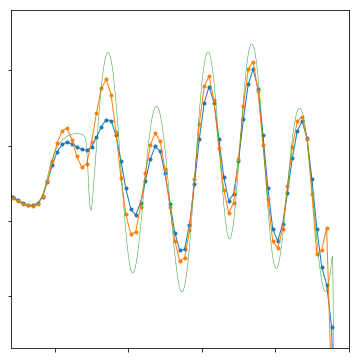

In [70]:
# Can use the stuff below for a basic comparison of two schemes... e.g., WENO and RBF-WENO
f, axes = plt.subplots(1, 1, figsize=(5,5))

# ref = np.loadtxt('shu_reference_pi.txt', dtype=float)
ref = np.loadtxt('shu_reference5.txt', dtype=float)
axes.plot(x_bar, q_FV_WENO5c[0], '.-', linewidth=1, label = 'Previous')
axes.plot(x_bar, q_FV_WENO4c[0], '.-', linewidth=1, label = 'Proposed')
# axes.plot(x_bar, q_FV_WENO4h[0], '.-', linewidth=1, label = 'ProposedH')
axes.plot(ref[0], ref[1], linewidth=.5, label = 'reference')
axes.set_xlim((0.2,2.5))
axes.set_ylim((2.65,4.9))
# # axes.legend(fontsize=14)
axes.xaxis.set_ticklabels([])
axes.yaxis.set_ticklabels([])

# Tighten the layout
plt.tight_layout(pad=0.75, w_pad=1.25, h_pad=1.0)
# plt.show()
#shift 0
plt.savefig('shu_sol_hllc_300_1_zoom_s5.png', bbox_inches='tight')
# plt.savefig('shu_sol_LLxF_1dx.pdf', bbox_inches='tight')
# 1/dx, 4.7

In [32]:
# # Can use the stuff below for a basic comparison of two schemes... e.g., WENO and RBF-WENO
# f, axes = plt.subplots(1, 1, figsize=(9,5))

# # ref = np.loadtxt('shu_reference_pi.txt', dtype=float)
# ref = np.loadtxt('shu_reference5.txt', dtype=float)
# axes.plot(x_bar, q_FV_WENO5c[0], '.-', linewidth=1, label = 'Previous')
# axes.plot(x_bar, q_FV_WENO4c[0], '.-', linewidth=1, label = 'Proposed')
# axes.plot(ref[0], ref[1], linewidth=.5, label = 'reference')
# axes.set_xlim((-4,3))
# axes.legend(fontsize=14)

# # Tighten the layout
# plt.tight_layout(pad=0.75, w_pad=1.25, h_pad=1.0)
# plt.show()

# # plt.savefig('shu_sol_hllc_1dx.pdf', bbox_inches='tight')
# plt.savefig('shu_sol_LLxF_1dx.pdf', bbox_inches='tight')
# # 1/dx, 4.7

In [33]:
# shu = np.zeros([4, N])
# shu[0,:] = x_bar
# shu[1:4,:] = q_FV_WENO4c
# np.savetxt('shu_sol_llxf_1dx.txt', shu, fmt='%f')

### Call the solvers

### Plot the results 